In [1]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x104076818>>

In [5]:
# extract data

i = -1

data_num = 2000 - 605 # 1395

wifi_loc_time = np.zeros(shape = (data_num, 524))

# 520 WAP
# FLOOR 2
# Building 1
# timestamp

# total data num = 19938

with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if (row[523] == 'BUILDINGID'):
            continue
        elif (row[523] is not '1' or row[522] is not '2'):
            continue
        i = i+1
        if (i > data_num):
            break
        # wifi
        wifi_loc_time[i-1][:520] = np.array(row[:520])
        # location x, y
        wifi_loc_time[i-1][520:522] = np.array(row[520:522])
        # userID
        wifi_loc_time[i-1][522] = np.array(row[526])
        # time stamp
        wifi_loc_time[i-1][-1] = np.array(row[-1])

In [3]:
# sort by timestamp
# https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]

# Create 2-D coordinates
# [ 0,  0,  0,  0,  0,  0,  0,  0,  0]
# https://stackoverflow.com/questions/25924244/creating-2d-dictionary-in-python

longitude_list = sorted(np.unique(wifi_loc_time[:, 520:521]))
latitude_list = sorted(np.unique(wifi_loc_time[:, 521:522]))

long_dict = {}
loc_dict = {}
for i in range(len(longitude_list)):
    long_dict[float(longitude_list[i])] = i
for i in range(len(latitude_list)):
    loc_dict[float(latitude_list[i])] = long_dict.copy()
    
# Initialize loc_dict
for i in range(len(latitude_list)):
    for j in range(len(longitude_list)):
        loc_dict[float(latitude_list[i])][float(longitude_list[j])] = 0

add_up = 0
        
# Refine loc_dict
# for i in range(len(latitude_list)):
#     for j in range(len(longitude_list)):
#         loc_dict[latitude_list[i]][longitude_list[j]]=i*len(longitude_list)+j

# create exist points as states
#for i in range(len(wifi_loc_time[:,520:521])):
    #print(i, float(wifi_loc_time[i,521:522]), float(wifi_loc_time[i,520:521]), loc_dict[float(wifi_loc_time[i,521:522])][float(wifi_loc_time[i,520:521])])
    #loc_dict[float(wifi_loc_time[i,521:522])][float(wifi_loc_time[i,520:521])] = loc_dict[float(wifi_loc_time[i,521:522])][float(wifi_loc_time[i,520:521])] + 1

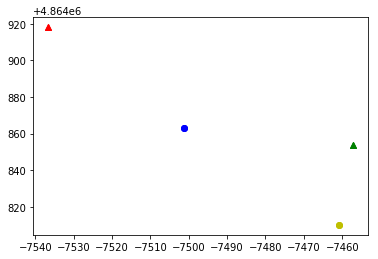

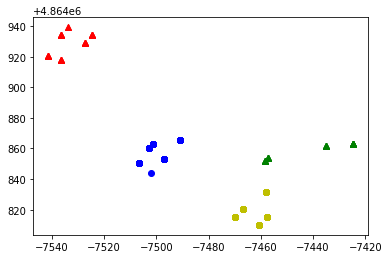

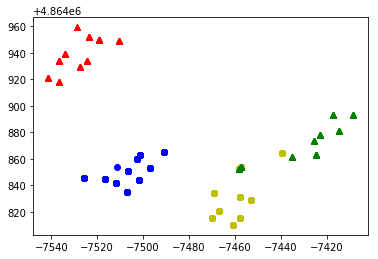

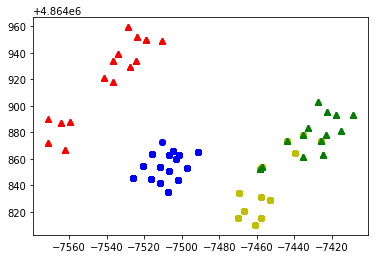

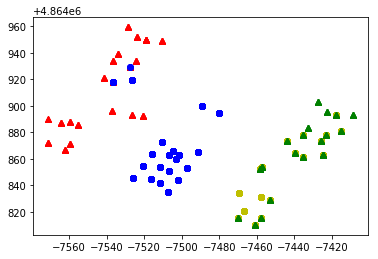

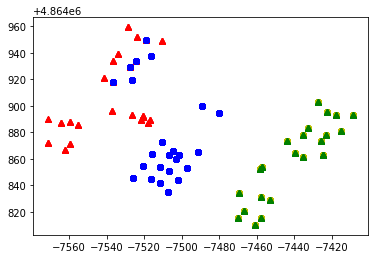

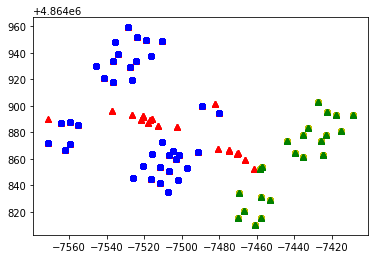

In [4]:
# partition data by users: array([ 2.,  4.,  9., 10.])
#                                471   374   316  234
np.unique(wifi_loc_time[:, 522])

user2 = 0
user4 = 0
user9 = 0
user10 = 0

# footprint: long, lat
user2_fp = np.zeros((471,2+520))
user4_fp = np.zeros((374,2+520))
user9_fp = np.zeros((316,2+520))
user10_fp = np.zeros((234,2+520))

for i in range(len(wifi_loc_time[:,522])):
    #print(wifi_loc_time[i,522])
    if (wifi_loc_time[i, 522] == 2):
        user2_fp[user2, :2] = np.array(wifi_loc_time[i, 520:522])
        user2_fp[user2, 2:] = np.array(wifi_loc_time[i, :520])
        user2 = user2+1
    elif (wifi_loc_time[i, 522] == 4):
        user4_fp[user4, :2] = np.array(wifi_loc_time[i, 520:522])
        user4_fp[user4, 2:] = np.array(wifi_loc_time[i, :520])
        user4 = user4+1
    elif (wifi_loc_time[i, 522] == 9):
        user9_fp[user9, :2] = np.array(wifi_loc_time[i, 520:522])
        user9_fp[user9, 2:] = np.array(wifi_loc_time[i, :520])
        user9 = user9+1
    elif (wifi_loc_time[i, 522] == 10):
        user10_fp[user10, :2] = np.array(wifi_loc_time[i, 520:522])
        user10_fp[user10, 2:] = np.array(wifi_loc_time[i, :520])
        user10 = user10+1
        
plt.plot(user2_fp[:2,0], user2_fp[:2,1], 'r^',user4_fp[:2,0], user4_fp[:2,1], 'bo', \
         user9_fp[:2,0], user9_fp[:2,1], 'yo',user10_fp[:2,0], user10_fp[:2,1], 'g^')

plt.show()

plt.plot(user2_fp[:50,0], user2_fp[:50,1], 'r^',user4_fp[:50,0], user4_fp[:50,1], 'bo', \
         user9_fp[:50,0], user9_fp[:50,1], 'yo',user10_fp[:50,0], user10_fp[:50,1], 'g^')
plt.show()

plt.plot(user2_fp[:100,0], user2_fp[:100,1], 'r^',user4_fp[:100,0], user4_fp[:100,1], 'bo', \
         user9_fp[:100,0], user9_fp[:100,1], 'yo',user10_fp[:100,0], user10_fp[:100,1], 'g^')
plt.show()

plt.plot(user2_fp[:150,0], user2_fp[:150,1], 'r^',user4_fp[:150,0], user4_fp[:150,1], 'bo', \
         user9_fp[:150,0], user9_fp[:150,1], 'yo',user10_fp[:150,0], user10_fp[:150,1], 'g^')
plt.show()

plt.plot(user2_fp[:200,0], user2_fp[:200,1], 'r^',user4_fp[:200,0], user4_fp[:200,1], 'bo', \
         user9_fp[:200,0], user9_fp[:200,1], 'yo',user10_fp[:200,0], user10_fp[:200,1], 'g^')
plt.show()

plt.plot(user2_fp[:234,0], user2_fp[:234,1], 'r^',user4_fp[:234,0], user4_fp[:234,1], 'bo', \
         user9_fp[:234,0], user9_fp[:234,1], 'yo',user10_fp[:234,0], user10_fp[:234,1], 'g^')
plt.show()

plt.plot(user2_fp[:,0], user2_fp[:,1], 'r^',user4_fp[:,0], user4_fp[:,1], 'bo', \
         user9_fp[:,0], user9_fp[:,1], 'yo',user10_fp[:,0], user10_fp[:,1], 'g^')
plt.show()

In [5]:
# small container
batch_num = 5
seq_window = 9

############ create model
iteration = 80
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=iteration)

In [6]:
state_count = 0

# find the start
for i in range(len(latitude_list)):
    for j in range(len(longitude_list)):
        if (user2_fp[0][0] == longitude_list[j] and user2_fp[0][1] == latitude_list[i]):
            print(i, j, loc_dict[latitude_list[i]][longitude_list[j]])
            if (loc_dict[latitude_list[i]][longitude_list[j]] == 0):
                loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                state_count = state_count + 1
                print("Start state location:", i, j, loc_dict[latitude_list[i]][longitude_list[j]])
                break

# state decision by user2        
for k in range(1,user2):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user2_fp[k][0] == longitude_list[j] and user2_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

65 11 0
Start state location: 65 11 0
1 65 11 0
2 65 11 0
3 65 11 0
4 65 11 0
5 65 11 0
6 65 11 0
7 65 11 0
8 65 11 0
9 71 10 1
10 71 10 1
11 71 10 1
12 71 10 1
13 71 10 1
14 71 10 1
15 71 10 1
16 71 10 1
17 71 10 1
18 71 10 1
19 67 8 2
20 67 8 2
21 67 8 2
22 67 8 2
23 67 8 2
24 67 8 2
25 67 8 2
26 67 8 2
27 67 8 2
28 68 15 3
29 68 15 3
30 68 15 3
31 68 15 3
32 68 15 3
33 68 15 3
34 68 15 3
35 68 15 3
36 68 15 3
37 68 15 3
38 70 19 4
39 70 19 4
40 70 19 4
41 70 19 4
42 70 19 4
43 70 19 4
44 70 19 4
45 70 19 4
46 70 19 4
47 70 19 4
48 73 13 5
49 73 13 5
50 73 13 5
51 73 13 5
52 73 13 5
53 73 13 5
54 73 13 5
55 73 13 5
56 73 13 5
57 73 13 5
58 76 25 6
59 76 25 6
60 76 25 6
61 76 25 6
62 76 25 6
63 76 25 6
64 76 25 6
65 76 25 6
66 76 25 6
67 76 25 6
68 76 25 6
69 76 25 6
70 76 25 6
71 76 25 6
72 76 25 6
73 76 25 6
74 76 25 6
75 76 25 6
76 76 25 6
77 76 25 6
78 75 36 7
79 75 36 7
80 75 36 7
81 75 36 7
82 75 36 7
83 75 36 7
84 75 36 7
85 75 36 7
86 75 36 7
87 75 36 7
88 77 20 8
89 77 20 8
9

In [7]:
# state decision by user4        
for k in range(user4):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user4_fp[k][0] == longitude_list[j] and user4_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

0 24 44 30
1 24 44 30
2 24 44 30
3 24 44 30
4 24 44 30
5 24 44 30
6 24 44 30
7 24 44 30
8 24 44 30
9 24 44 30
10 29 46 31
11 29 46 31
12 29 46 31
13 29 46 31
14 29 46 31
15 29 46 31
16 29 46 31
17 29 46 31
18 29 46 31
19 29 46 31
20 20 41 32
21 20 41 32
22 20 41 32
23 20 41 32
24 20 41 32
25 20 41 32
26 20 41 32
27 20 41 32
28 20 41 32
29 15 45 48
30 15 45 48
31 15 45 48
32 15 45 48
33 15 45 48
34 15 45 48
35 15 45 48
36 15 45 48
37 15 45 48
38 15 45 48
39 12 38 33
40 12 38 33
41 12 38 33
42 12 38 33
43 12 38 33
44 12 38 33
45 12 38 33
46 12 38 33
47 12 38 33
48 12 38 33
49 9 43 49
50 9 43 49
51 9 43 49
52 9 43 49
53 9 43 49
54 9 43 49
55 9 43 49
56 9 43 49
57 9 43 49
58 9 43 49
59 8 33 34
60 8 33 34
61 8 33 34
62 8 33 34
63 8 33 34
64 8 33 34
65 8 33 34
66 8 33 34
67 8 33 34
68 8 33 34
69 7 37 50
70 7 37 50
71 7 37 50
72 7 37 50
73 7 37 50
74 7 37 50
75 7 37 50
76 7 37 50
77 7 37 50
78 7 37 50
79 10 29 35
80 10 29 35
81 10 29 35
82 10 29 35
83 10 29 35
84 10 29 35
85 10 29 35
86 10 29

In [8]:
# state decision by user9        
for k in range(user9):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user9_fp[k][0] == longitude_list[j] and user9_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

0 0 60 59
1 0 60 59
2 0 60 59
3 0 60 59
4 0 60 59
5 0 60 59
6 0 60 59
7 0 60 59
8 0 60 59
9 0 60 59
10 2 63 60
11 2 63 60
12 2 63 60
13 2 63 60
14 2 63 60
15 2 63 60
16 2 63 60
17 2 63 60
18 2 63 60
19 2 63 60
20 1 54 61
21 1 54 61
22 1 54 61
23 1 54 61
24 1 54 61
25 1 54 61
26 1 54 61
27 1 54 61
28 1 54 61
29 1 54 61
30 3 57 62
31 3 57 62
32 3 57 62
33 3 57 62
34 3 57 62
35 3 57 62
36 3 57 62
37 3 57 62
38 3 57 62
39 3 57 62
40 5 62 63
41 5 62 63
42 5 62 63
43 5 62 63
44 5 62 63
45 5 62 63
46 5 62 63
47 5 62 63
48 5 62 63
49 5 62 63
50 6 56 64
51 6 56 64
52 6 56 64
53 6 56 64
54 6 56 64
55 6 56 64
56 6 56 64
57 6 56 64
58 6 56 64
59 6 56 64
60 4 65 65
61 4 65 65
62 4 65 65
63 4 65 65
64 4 65 65
65 4 65 65
66 4 65 65
67 4 65 65
68 4 65 65
69 4 65 65
70 14 61 46
71 14 61 46
72 14 61 46
73 14 61 46
74 14 61 46
75 14 61 46
76 14 61 46
77 14 61 46
78 14 61 46
79 14 61 46
80 17 64 45
81 17 64 45
82 17 64 45
83 17 64 45
84 17 64 45
85 17 64 45
86 17 64 45
87 17 64 45
88 17 64 45
89 17 64 45


In [9]:
# state decision by user10        
for k in range(user10):
    for i in range(len(latitude_list)):
        for j in range(len(longitude_list)):
            if (user10_fp[k][0] == longitude_list[j] and user10_fp[k][1] == latitude_list[i]):
                if (loc_dict[latitude_list[i]][longitude_list[j]] == 0 and (i!=65 and j!=11)):
                    loc_dict[latitude_list[i]][longitude_list[j]] = state_count
                    state_count = state_count + 1
                print(k, i, j, loc_dict[latitude_list[i]][longitude_list[j]])

0 17 64 45
1 17 64 45
2 17 64 45
3 17 64 45
4 17 64 45
5 17 64 45
6 17 64 45
7 17 64 45
8 17 64 45
9 17 64 45
10 14 61 46
11 14 61 46
12 14 61 46
13 14 61 46
14 14 61 46
15 14 61 46
16 14 61 46
17 14 61 46
18 14 61 46
19 14 61 46
20 21 68 70
21 21 68 70
22 21 68 70
23 21 68 70
24 21 68 70
25 21 68 70
26 21 68 70
27 21 68 70
28 21 68 70
29 21 68 70
30 23 73 71
31 23 73 71
32 23 73 71
33 23 73 71
34 23 73 71
35 23 73 71
36 23 73 71
37 23 73 71
38 23 73 71
39 23 73 71
40 23 73 71
41 23 73 71
42 23 73 71
43 23 73 71
44 23 73 71
45 23 73 71
46 23 73 71
47 23 73 71
48 23 73 71
49 23 73 71
50 38 72 69
51 38 72 69
52 38 72 69
53 38 72 69
54 38 72 69
55 38 72 69
56 38 72 69
57 38 72 69
58 38 72 69
59 38 72 69
60 40 74 72
61 40 74 72
62 40 74 72
63 40 74 72
64 40 74 72
65 40 74 72
66 40 74 72
67 40 74 72
68 40 74 72
69 40 74 72
70 42 77 73
71 42 77 73
72 42 77 73
73 42 77 73
74 42 77 73
75 42 77 73
76 42 77 73
77 42 77 73
78 42 77 73
79 42 77 73
80 58 76 74
81 58 76 74
82 58 76 74
83 58 76 74
84

In [10]:
# NOT YET
# train by user2 dataset 471 = 3 x 157

total_batch_num = 157+124+105+78

batch_num = 157
seq_window = 3

iter_batch = 0
iter_window = 0

batch_wifi = np.zeros((total_batch_num, seq_window, 520))
batch_loc = np.zeros((total_batch_num, seq_window), dtype = int)
        
for i in range(user2):
    batch_wifi[iter_batch][iter_window] = user2_fp[i][2:]
    batch_loc[iter_batch,iter_window] = loc_dict[float(user2_fp[i][1])][float(user2_fp[i][0])]
    if (iter_window == (seq_window-1)):
        iter_window = 0
        if (iter_batch < (batch_num-1)):
            iter_batch = iter_batch + 1
        elif (iter_batch == (batch_num-1)):
            iter_batch = iter_batch + 1
            break
    else:
        iter_window = iter_window + 1

# 374 = 3 * 124 (372)

batch_num = batch_num + 124

for i in range(user4):
    batch_wifi[iter_batch][iter_window] = user4_fp[i][2:]
    batch_loc[iter_batch,iter_window] = loc_dict[float(user4_fp[i][1])][float(user4_fp[i][0])]
    if (iter_window == (seq_window-1)):
        iter_window = 0
        if (iter_batch < (batch_num-1)):
            iter_batch = iter_batch + 1
        elif (iter_batch == (batch_num-1)):
            iter_batch = iter_batch + 1
            break
    else:
        iter_window = iter_window + 1
        
# 316 = 3 * 105 (315)  234

batch_num = batch_num + 105

for i in range(user9):
    batch_wifi[iter_batch][iter_window] = user9_fp[i][2:]
    batch_loc[iter_batch,iter_window] = loc_dict[float(user9_fp[i][1])][float(user9_fp[i][0])]
    if (iter_window == (seq_window-1)):
        iter_window = 0
        if (iter_batch < (batch_num-1)):
            iter_batch = iter_batch + 1
        elif (iter_batch == (batch_num-1)):
            iter_batch = iter_batch + 1
            break
    else:
        iter_window = iter_window + 1
        
# 234 = 3 * 78

batch_num = batch_num + 78

for i in range(user10):
    batch_wifi[iter_batch][iter_window] = user10_fp[i][2:]
    batch_loc[iter_batch,iter_window] = loc_dict[float(user10_fp[i][1])][float(user10_fp[i][0])]
    if (iter_window == (seq_window-1)):
        iter_window = 0
        if (iter_batch < (batch_num-1)):
            iter_batch = iter_batch + 1
        elif (iter_batch == (batch_num-1)):
            iter_batch = iter_batch + 1
            break
    else:
        iter_window = iter_window + 1

for i in range(total_batch_num):
    print(i, batch_loc[i])
        
ssvm.fit(batch_wifi, batch_loc)

0 [0 0 0]
1 [0 0 0]
2 [0 0 0]
3 [1 1 1]
4 [1 1 1]
5 [1 1 1]
6 [1 2 2]
7 [2 2 2]
8 [2 2 2]
9 [2 3 3]
10 [3 3 3]
11 [3 3 3]
12 [3 3 4]
13 [4 4 4]
14 [4 4 4]
15 [4 4 4]
16 [5 5 5]
17 [5 5 5]
18 [5 5 5]
19 [5 6 6]
20 [6 6 6]
21 [6 6 6]
22 [6 6 6]
23 [6 6 6]
24 [6 6 6]
25 [6 6 6]
26 [7 7 7]
27 [7 7 7]
28 [7 7 7]
29 [7 8 8]
30 [8 8 8]
31 [8 8 8]
32 [8 8 9]
33 [9 9 9]
34 [9 9 9]
35 [9 9 9]
36 [10 10 10]
37 [11 11 11]
38 [11 11 11]
39 [11 11 11]
40 [11 12 12]
41 [12 12 12]
42 [12 12 12]
43 [12 12 13]
44 [13 13 13]
45 [13 13 13]
46 [13 13 13]
47 [14 14 14]
48 [14 14 14]
49 [14 14 14]
50 [14 15 15]
51 [15 15 15]
52 [15 15 15]
53 [15 15 16]
54 [16 16 16]
55 [16 16 16]
56 [16 16 16]
57 [17 17 17]
58 [17 17 17]
59 [17 17 17]
60 [17 18 18]
61 [18 18 18]
62 [18 18 18]
63 [18 18 18]
64 [19 19 19]
65 [19 19 19]
66 [19 19 19]
67 [20 20 20]
68 [20 20 20]
69 [20 20 20]
70 [20 21 21]
71 [21 21 21]
72 [21 21 22]
73 [22 22 22]
74 [22 22 22]
75 [22 22 22]
76 [23 23 23]
77 [23 23 23]
78 [23 23 23]
79 [23 24 24

FrankWolfeSSVM(C=0.1, batch_mode=False, check_dual_every=10,
        do_averaging=True, line_search=True, logger=None, max_iter=80,
        model=ChainCRF(n_states: 79, inference_method: max-product),
        n_jobs=1, random_state=None, sample_method='perm',
        show_loss_every=0, tol=0.001, verbose=0)

In [11]:
# Testing
# extract data

i = -1

data_num_v = 86 # 86 in validation dataset

wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))

# 520 WAP
# FLOOR 2
# Building 1
# timestamp

# total data num = 19938

with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
    spamreader_v = csv.reader(v_csvfile, delimiter=',')
    for row in spamreader_v:
        if (row[523] == 'BUILDINGID'):
            continue
        elif (row[523] is not '1' or row[522] is not '2'):
            continue
        i = i+1
        #if (i > data_num):
        #    break
        # wifi
        wifi_loc_time_v[i-1][:520] = np.array(row[:520])
        # location x, y
        wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
        # userID
        wifi_loc_time_v[i-1][522] = np.array(row[526])
        # time stamp
        wifi_loc_time_v[i-1][-1] = np.array(row[-1])

In [12]:
# sort by timestamp
wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]

longitude_list_v = sorted(np.unique(wifi_loc_time_v[:, 520:521]))
latitude_list_v = sorted(np.unique(wifi_loc_time_v[:, 521:522]))

long_dict_v = {}
loc_dict_v = {}
for i in range(len(longitude_list_v)):
    long_dict_v[float(longitude_list_v[i])] = i
for i in range(len(latitude_list_v)):
    loc_dict_v[float(latitude_list_v[i])] = long_dict_v.copy()
    
min_dis = 0
max_ind = -1
distance  = 0
cumulative_distance = 0

# find the nearest loc_dict_v
for i in range(len(latitude_list_v)):
    for j in range(len(longitude_list_v)):
        min_dis = sys.float_info.max
        max_ind = -1
        for x in range(len(latitude_list)):
            for y in range(len(longitude_list)):
                distance = math.sqrt(pow(latitude_list[x]-latitude_list_v[i],2) \
                                     +pow(longitude_list[y]-longitude_list_v[j], 2))
                if (min_dis > distance):
                    if (loc_dict[float(latitude_list[x])][float(longitude_list[y])] != 0 or \
                       (loc_dict[float(latitude_list[x])][float(longitude_list[y])] == 0\
                              and x == 65 and y == 11)):
                        min_dis = distance
                        max_ind = loc_dict[float(latitude_list[x])][float(longitude_list[y])]
        cumulative_distance = cumulative_distance + min_dis
        loc_dict_v[latitude_list_v[i]][longitude_list_v[j]] = max_ind
        if (min_dis > 20):
            print(i, j, min_dis, max_ind)
print(cumulative_distance/(len(latitude_list_v)*len(longitude_list_v)))

0 0 52.19750068590108 51
0 1 48.89374530426823 51
0 2 45.44541658042998 51
0 3 37.62495899685668 51
0 4 36.84423944954561 51
0 5 35.42663982646444 51
0 6 35.12366434953198 51
0 7 31.027673917692503 50
0 8 30.746296605003916 50
0 9 30.44558750499818 50
0 10 30.13719156393056 50
0 11 28.7733832313789 50
0 12 28.435337517863072 50
0 13 28.044569890463617 50
0 14 27.765068613388785 50
0 15 27.608194587976655 50
0 16 26.644568147464508 50
0 17 26.180128010183022 50
0 18 25.944918239471146 50
0 19 25.81997327484255 50
0 20 24.664146048063497 50
0 21 24.604596007978635 50
0 22 24.583431826800457 50
0 23 24.416214417899006 50
0 24 23.97835307635992 50
0 25 23.971857038016953 50
0 26 23.966400647891145 50
0 27 23.95948966132228 50
0 28 23.97785230745655 50
0 29 24.000489018132757 50
0 30 24.147046154257037 50
0 31 24.166623995795042 50
0 32 24.313863591046008 50
0 33 24.359358722193086 50
0 34 24.43972751061922 50
0 35 24.53508480112417 50
0 36 24.621408666979512 50
0 37 24.70664842024927 50
0 

9 75 21.359112159028683 71
9 76 21.796076463580157 71
9 77 21.818998754952535 71
9 78 22.415856882916856 71
10 0 24.581067785210298 14
10 1 24.458253804602887 14
10 2 25.290834022580018 14
10 67 20.73754819642008 71
10 68 20.614760708704093 71
10 69 20.61379761993885 71
10 70 20.6179513214442 71
10 71 20.63407711552062 71
10 72 20.686829956763287 71
10 73 20.710493646769713 71
10 74 20.74657296957527 71
10 75 20.76865097664024 71
10 76 21.217778874655224 71
10 77 21.24132523728576 71
10 78 21.853966023652177 71
11 0 23.357117543158246 14
11 1 23.22783299479697 14
11 2 24.102952765615633 14
11 76 20.02185721706061 71
11 77 20.046808321594476 71
11 78 20.69484131394924 71
12 0 22.064774928698817 14
12 1 21.927872180478527 14
12 2 22.852826624965314 14
13 0 22.064774925006347 14
13 1 21.927872176763003 14
13 2 22.852826621400173 14
14 0 21.91671924194477 14
14 1 21.778885830994664 14
14 2 22.70990916817634 14
15 0 21.89514532716325 14
15 1 21.757175244200862 14
15 2 22.689089470364085 14


83 65 47.849955963567545 77
83 66 47.60785940430604 77
83 67 47.51996108517051 77
83 68 47.564715180205006 77
83 69 47.57377380888727 77
83 70 47.595247104082716 77
83 71 47.62602565424005 77
83 72 47.68792022319941 77
83 73 47.71062505420621 77
83 74 47.742621153527644 77
83 75 47.76112542265987 77
83 76 48.075675607004385 77
83 77 48.090705047246665 77
83 78 48.46405606211968 77
8.663411982974417


In [13]:
# !!!!!!!!!!!!!!!!
batch_num = int(86/seq_window) # 3 * 28 = 84
print("Validating data", batch_num)
batch_wifi_v = np.zeros((batch_num + 1, seq_window, 520))
batch_loc_v = np.zeros((batch_num + 1, seq_window), dtype = int)

batch_wifi_v[0][0] = user2_fp[0][:520]
batch_loc_v[0,0] = loc_dict[float(user2_fp[0][1])][float(user2_fp[0][0])]

iter_window = 0
iter_batch = 1

for i in range(len(wifi_loc_time_v)):
    batch_wifi_v[iter_batch][iter_window] = wifi_loc_time_v[i][:520]
    batch_loc_v[iter_batch,iter_window] = loc_dict_v[float(wifi_loc_time_v[i][521])][float(wifi_loc_time_v[i][520])]
    if (iter_window == (seq_window-1)):
        iter_window = 0
        if (iter_batch < (batch_num)):
            iter_batch = iter_batch + 1
        elif (iter_batch == (batch_num)):
            iter_batch = iter_batch + 1
            break
    else:
        iter_window = iter_window + 1
        
for i in range(batch_num+1):
    print(i, batch_loc_v[i])

Validating data 28
0 [0 0 0]
1 [51 51 35]
2 [35 34 51]
3 [51 51 66]
4 [78 76 30]
5 [33 35 38]
6 [37 34 30]
7 [11 70 78]
8 [74 72 65]
9 [ 0 29 59]
10 [61 22 38]
11 [62 15 31]
12 [52 26 26]
13 [66 38 26]
14 [71 72 36]
15 [33 78 76]
16 [18 30 45]
17 [37 36 63]
18 [34 35 62]
19 [70 32 70]
20 [26 69 29]
21 [74 29 27]
22 [26 70 72]
23 [68 78 11]
24 [2 5 4]
25 [ 5  8 23]
26 [38 39 70]
27 [70 69 72]
28 [71 71 74]


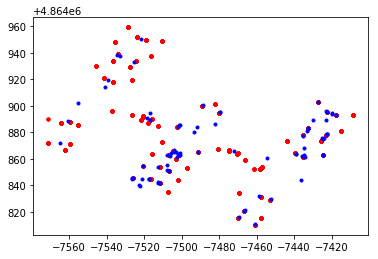

In [14]:
# # plot exist points both train and test
plt.plot(wifi_loc_time[:, 520:521], wifi_loc_time[:, 521:522], 'r.', wifi_loc_time_v[:, 520:521], wifi_loc_time_v[:, 521:522], 'b.')

In [27]:
# scoring the validation result
pred_batch_v = ssvm.predict(batch_wifi_v)
total_error = 0
total_error_loc_dict_space = 0

validation_latitude = []
validation_longitude = []

gt_validation_latitude_loc_dict_space = []
gt_validation_longitude_loc_dict_space = []

for i in range(1,batch_num+1):
    for j in range(seq_window):
        if (batch_loc_v[i][j] == 0):
            gt_validation_latitude_loc_dict_space.append(latitude_list[65])
            gt_validation_longitude_loc_dict_space.append(longitude_list[11])
            continue
        for x in range(len(latitude_list)):
            for y in range(len(longitude_list)):
                if (batch_loc_v[i][j] == loc_dict[latitude_list[x]][longitude_list[y]]):
                    gt_validation_latitude_loc_dict_space.append(latitude_list[x])
                    gt_validation_longitude_loc_dict_space.append(longitude_list[y])
                    #print(i, j, batch_loc_v[i][j], x, y, len(gt_validation_latitude_loc_dict_space))
                    break

iter_validating_data = 0
window_1 = 0
window_2 = 0
window_0 = 0
for i in range(1,batch_num+1):
    for j in range(seq_window):
        for x in range(len(latitude_list)):
            for y in range(len(longitude_list)):
                if (pred_batch_v[i][j] == loc_dict[latitude_list[x]][longitude_list[y]]):
                    validation_latitude.append(latitude_list[x])
                    validation_longitude.append(longitude_list[y])
                    total_error += math.sqrt(pow(latitude_list[x] - wifi_loc_time_v[iter_validating_data][521],2)+pow(longitude_list[y] - wifi_loc_time_v[iter_validating_data][520],2))
                    print(iter_validating_data, i, j)
                    print("state:", loc_dict[latitude_list[x]][longitude_list[y]], batch_loc_v[i][j], "       Distance:",math.sqrt(pow(latitude_list[x] - wifi_loc_time_v[iter_validating_data][521],2)+pow(longitude_list[y] - wifi_loc_time_v[iter_validating_data][520],2)))
                    break
        if (j==0):
            window_0 += math.sqrt(pow(validation_latitude[iter_validating_data] - gt_validation_latitude_loc_dict_space[iter_validating_data],2)+pow(validation_longitude[iter_validating_data] - gt_validation_longitude_loc_dict_space[iter_validating_data],2))
        if (j==1):
            window_1 += math.sqrt(pow(validation_latitude[iter_validating_data] - gt_validation_latitude_loc_dict_space[iter_validating_data],2)+pow(validation_longitude[iter_validating_data] - gt_validation_longitude_loc_dict_space[iter_validating_data],2))
        if (j==2):
            window_2 += math.sqrt(pow(validation_latitude[iter_validating_data] - gt_validation_latitude_loc_dict_space[iter_validating_data],2)+pow(validation_longitude[iter_validating_data] - gt_validation_longitude_loc_dict_space[iter_validating_data],2))
        total_error_loc_dict_space += math.sqrt(pow(validation_latitude[iter_validating_data] - gt_validation_latitude_loc_dict_space[iter_validating_data],2)+pow(validation_longitude[iter_validating_data] - gt_validation_longitude_loc_dict_space[iter_validating_data],2))
        iter_validating_data += 1
        
print("RMSE: ", total_error/84)
print("RMSE in loc_dict space:", total_error_loc_dict_space/84)
print("RMSE by window: ", window_0/28, window_1/28, window_2/28)

0 1 0
state: 35 51        Distance: 7.986299824222269
1 1 1
state: 24 51        Distance: 50.21395204072407
2 1 2
state: 35 35        Distance: 4.612695212934535
3 2 0
state: 35 35        Distance: 1.1557655210335969
4 2 1
state: 35 34        Distance: 5.58115121041399
5 2 2
state: 36 51        Distance: 16.502037039683483
6 3 0
state: 22 51        Distance: 44.8619009238817
7 3 1
state: 22 51        Distance: 45.2060831911134
8 3 2
state: 66 66        Distance: 0.8269385237634149
9 4 0
state: 73 78        Distance: 18.23253221566211
10 4 1
state: 75 76        Distance: 14.567887817651883
11 4 2
state: 33 30        Distance: 13.703914288885416
12 5 0
state: 33 33        Distance: 0.39653816866483793
13 5 1
state: 35 35        Distance: 1.1557655220569703
14 5 2
state: 35 38        Distance: 22.70496673313867
15 6 0
state: 33 37        Distance: 11.75391155452462
16 6 1
state: 35 34        Distance: 4.837763783540406
17 6 2
state: 35 30        Distance: 24.25442743330542
18 7 0
state: 1

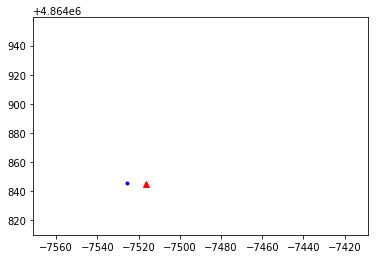

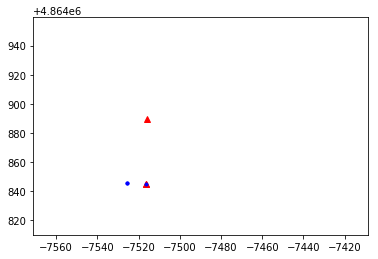

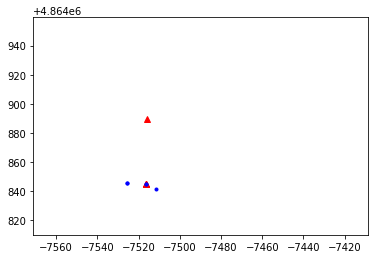

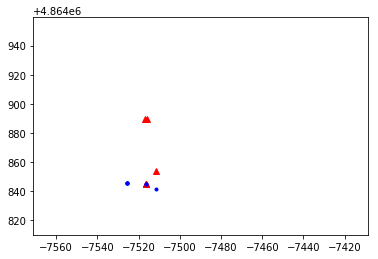

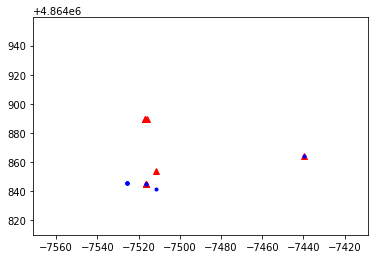

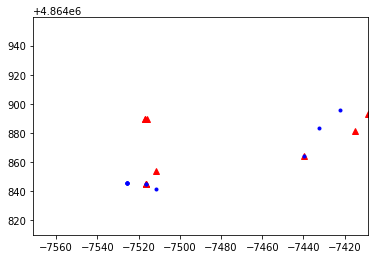

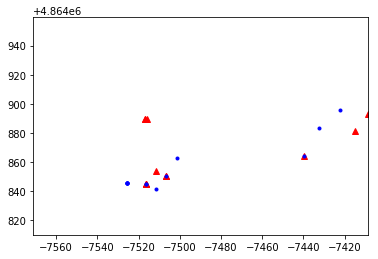

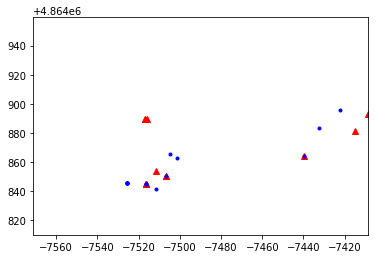

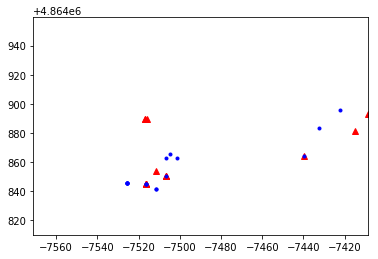

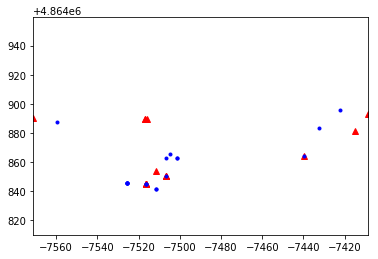

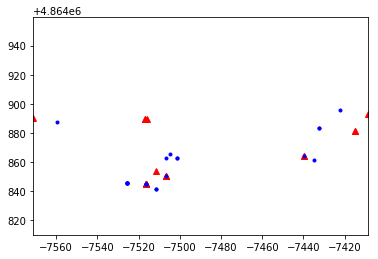

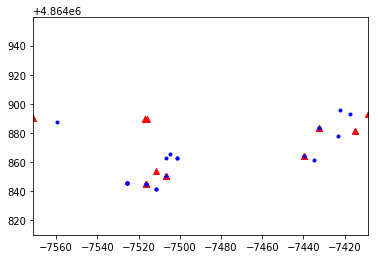

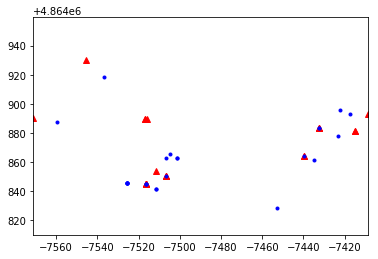

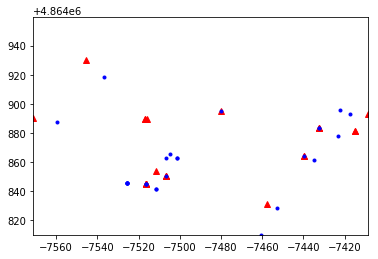

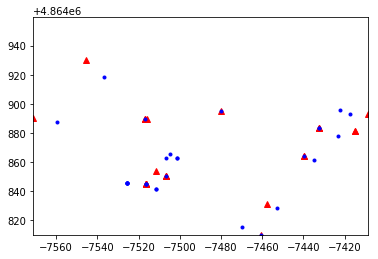

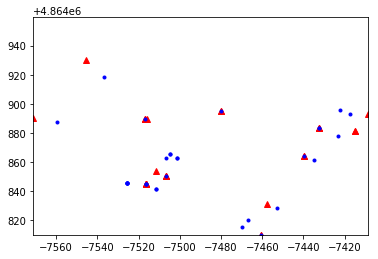

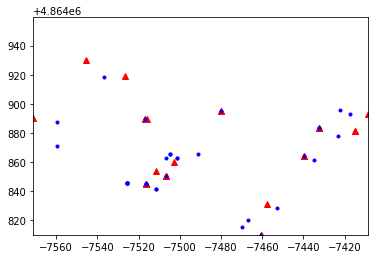

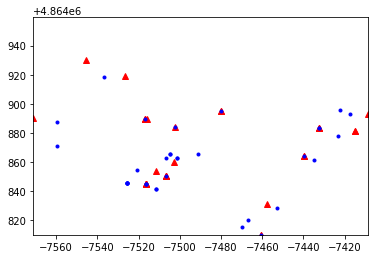

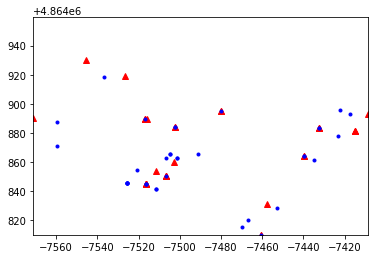

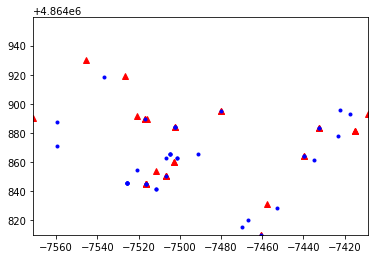

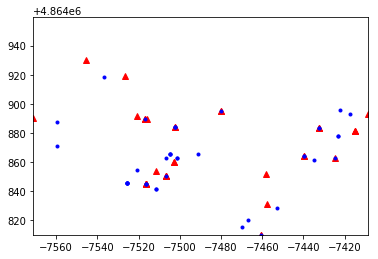

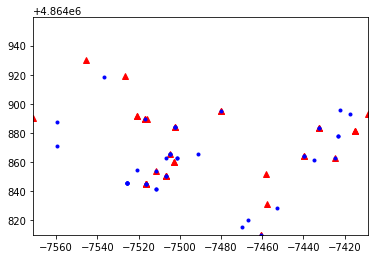

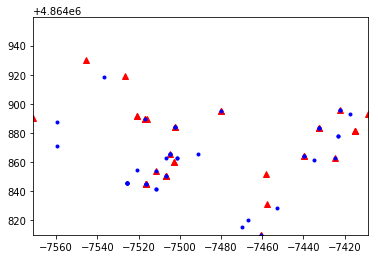

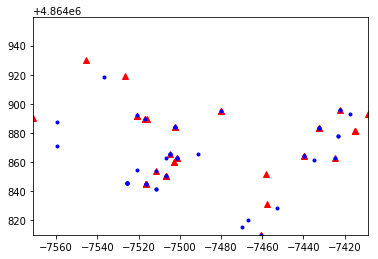

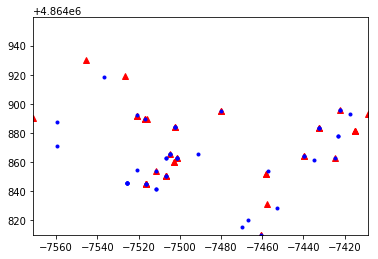

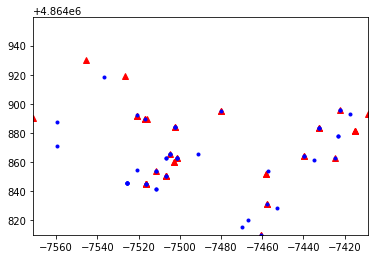

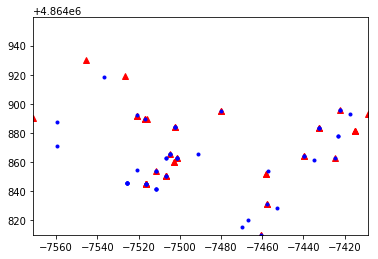

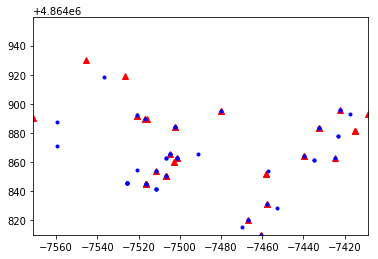

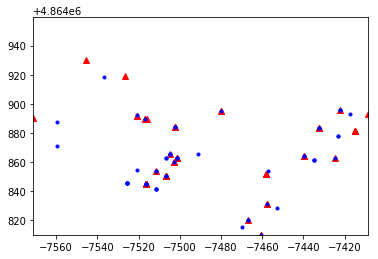

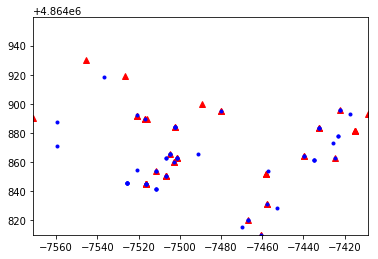

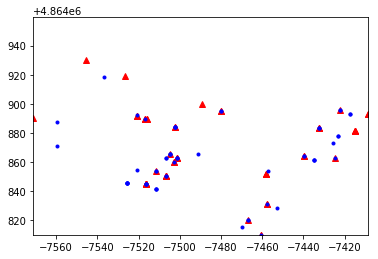

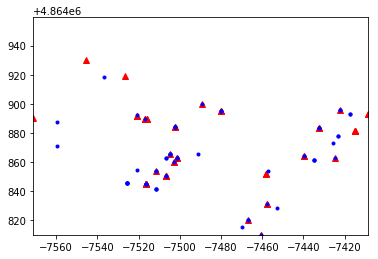

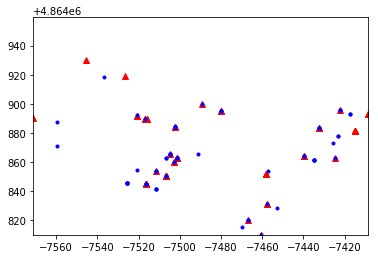

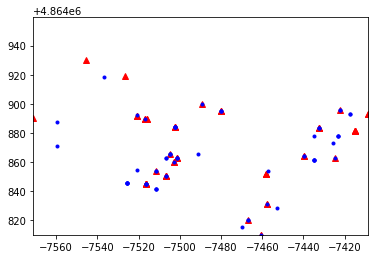

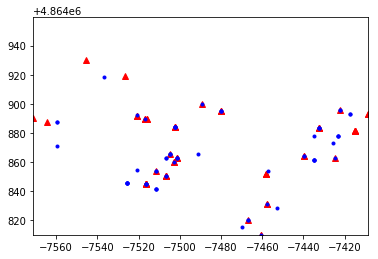

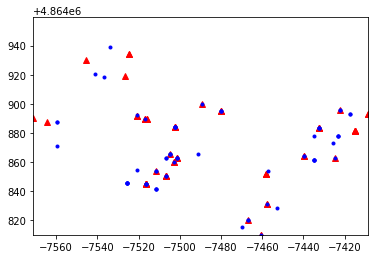

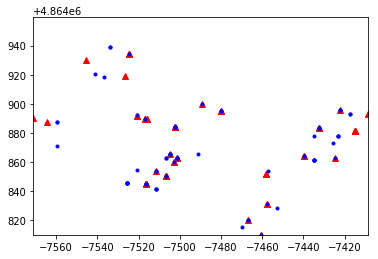

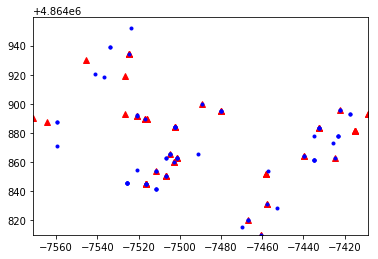

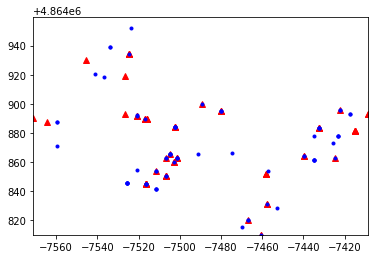

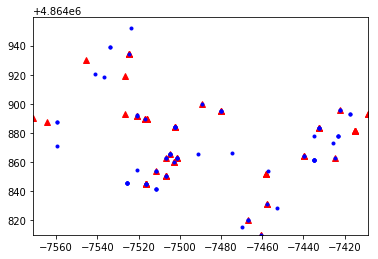

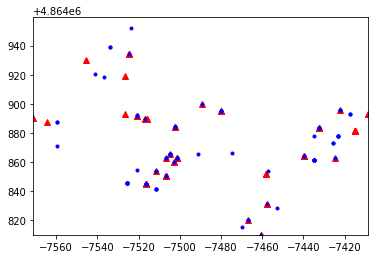

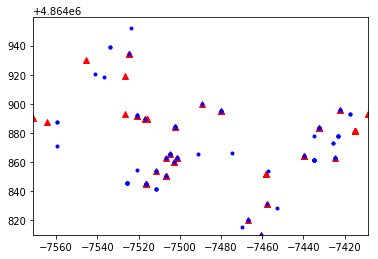

In [16]:
for i in range(1, 84, 2):
    axes = plt.gca()
    axes.set_xlim([min(longitude_list),max(longitude_list)])
    axes.set_ylim([min(latitude_list),max(latitude_list)])
    plt.plot(validation_longitude[:i], validation_latitude[:i], 'r^', gt_validation_longitude_loc_dict_space[:i], gt_validation_latitude_loc_dict_space[:i], 'b.')
    plt.show()

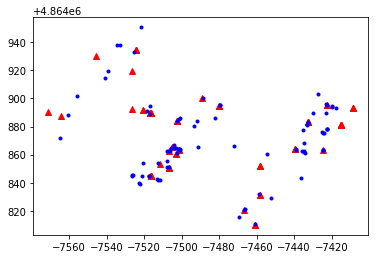

In [17]:
plt.plot(validation_longitude, validation_latitude, 'r^', wifi_loc_time_v[:, 520:521], wifi_loc_time_v[:, 521:522], 'b.')

In [18]:
print(len(gt_validation_latitude_loc_dict_space))

84


In [19]:
np.set_printoptions(threshold=np.nan)
print(batch_loc_v)

[[ 0  0  0]
 [51 51 35]
 [35 34 51]
 [51 51 66]
 [78 76 30]
 [33 35 38]
 [37 34 30]
 [11 70 78]
 [74 72 65]
 [ 0 29 59]
 [61 22 38]
 [62 15 31]
 [52 26 26]
 [66 38 26]
 [71 72 36]
 [33 78 76]
 [18 30 45]
 [37 36 63]
 [34 35 62]
 [70 32 70]
 [26 69 29]
 [74 29 27]
 [26 70 72]
 [68 78 11]
 [ 2  5  4]
 [ 5  8 23]
 [38 39 70]
 [70 69 72]
 [71 71 74]]


In [20]:
print(len(batch_loc_v))

29


In [21]:
# WGS84
# https://pcjericks.github.io/py-gdalogr-cookbook/projection.html
# http://www.sunriver.com.tw/grid_tm2.htm

# environment

long = -7695.9387549299299000 - (-7299.786516730871000)
lat = 4864745.7450159714 - 4865017.3646842018
print(long, lat, math.sqrt(pow(long,2)+pow(lat,2)), long*lat)
print(15.216780012680832/math.sqrt(2))

-396.15223819905896 -271.6196682304144 480.32680541452646 107602.7395083645
10.759888334790535
